# Exercise 11: Fit — Exponential background + Gaussian signal

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [28]:
# --- 1. Load unlabeled CSV (generated previously as sample_lec11.csv) ---
df = pd.read_csv("sample_ex11.csv")
x = df["x"].values
print("Loaded:", df.shape, "rows")

Loaded: (52000, 1) rows


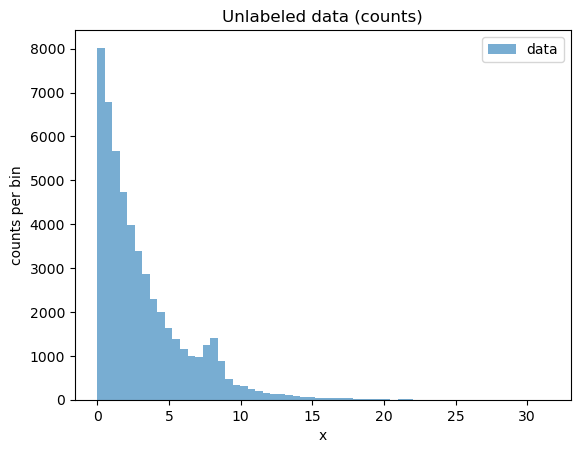

In [21]:
# --- 2. Build histogram (counts) with fixed bins ---
bins = 60
xmin, xmax = float(x.min()), float(x.max())
bin_edges = np.linspace(xmin, xmax, bins + 1)
counts, edges = np.histogram(x, bins=bin_edges)
centers = 0.5 * (edges[1:] + edges[:-1])
width = edges[1] - edges[0]  # uniform width assumed here

# Poisson uncertainties for weighted fit
sigma_y = np.sqrt(np.maximum(counts, 1.0))

# Visualize data
plt.figure()
plt.bar(centers, counts, width=width, alpha=0.6, label="data")
plt.xlabel("x")
plt.ylabel("counts per bin")
plt.title("Unlabeled data (counts)")
plt.legend(); plt.show()

In [22]:
# --- 3. Define model: counts per bin ~ width * [B * exp(-x/tau) + S * Gauss(x; mu, sigma)] ---
def gauss_pdf(xc, mu, sigma):
    return (1.0 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-0.5 * ((xc - mu)/sigma)**2)

def bkg_counts(xc, B, tau):
    return width * (B * np.exp(-xc / tau))

def full_counts(xc, B, tau, S, mu, sigma):
    return bkg_counts(xc, B, tau) + width * (S * gauss_pdf(xc, mu, sigma))


In [24]:
# --- 4. Robust initial guesses (sideband pre-fit) ---
# Left sideband (where signal contribution is negligible)
x_sb_max = float(np.quantile(x, 0.60))
side_mask = centers <= x_sb_max

# initial rough seeds
B0 = max(counts[0] / width, 10.0)
q25 = np.quantile(x, 0.25)
tau0 = max(q25 if q25 > 0 else 1.0, 0.5)

pars_bkg, _ = curve_fit(
    bkg_counts,
    centers[side_mask], counts[side_mask],
    p0=[B0, tau0],
    sigma=sigma_y[side_mask], absolute_sigma=True,
    bounds=([0.0, 0.05], [np.inf, 50.0]),
    maxfev=100000,
)
B_fit, tau_fit = pars_bkg
print(f"Sideband fit (x <= {x_sb_max:.2f}) → B={B_fit:.3g}, tau={tau_fit:.3g}")

# Residuals after subtracting fitted background
residual = counts - bkg_counts(centers, B_fit, tau_fit)
residual = np.clip(residual, 0.0, None)

# Seed mu from residual peak (ignore very low-x where exp dominates)
res_mask = centers > x_sb_max  # look to the right of sideband
if residual[res_mask].sum() > 0:
    imax = np.argmax(residual[res_mask])
    mu0 = float(centers[res_mask][imax])
else:
    # fallback: global mode of centers weighted by residual
    mu0 = float(np.average(centers, weights=residual + 1e-6))

# Seed sigma from residual RMS around mu0
w = residual.copy()
w /= w.sum() + 1e-12
sigma0 = max(np.sqrt(np.sum(w * (centers - mu0)**2)), width)

# Seed S as residual area (counts per bin summed)
S0 = float(residual.sum())

print(f"Seeds → mu0≈{mu0:.3f}, sigma0≈{sigma0:.3f}, S0≈{S0:.1f}")


Sideband fit (x <= 2.92) → B=1.67e+04, tau=3.01
Seeds → mu0≈8.129, sigma0≈1.996, S0≈2124.4


In [25]:
# --- 5. Step-2: fit only (S,mu,sigma) with background fixed ---
win_half = 4.0 * max(sigma0, width)
win_mask = (centers >= mu0 - win_half) & (centers <= mu0 + win_half)

def counts_sig_only(xc, S, mu, sigma):
    return bkg_counts(xc, B_fit, tau_fit) + width * (S * gauss_pdf(xc, mu, sigma))

pars_sig, cov_sig = curve_fit(
    counts_sig_only,
    centers[win_mask], counts[win_mask],
    p0=[max(S0, 10.0), mu0, sigma0],
    sigma=sigma_y[win_mask], absolute_sigma=True,
    bounds=([0.0, mu0 - 2.0, width/2], [np.inf, mu0 + 2.0, 5.0]),
    maxfev=100000,
)
S1, mu1, sigma1 = pars_sig
print(f"Signal-on-fixed-bkg (local) → S={S1:.1f}, mu={mu1:.3f}, sigma={sigma1:.3f}")


Signal-on-fixed-bkg (local) → S=1959.0, mu=8.042, sigma=0.494


In [26]:
# --- 6. Step-3: global 5-par fit initialized from previous steps ---
pars0 = [B_fit, tau_fit, S1, mu1, sigma1]
pars, cov = curve_fit(
    full_counts,
    centers, counts,
    p0=pars0,
    sigma=sigma_y, absolute_sigma=True,
    bounds=([0.0, 0.05, 0.0, xmin, width/2], [np.inf, 50.0, np.inf, xmax, 5.0]),
    maxfev=200000,
)
B, tau, S, mu, sigma = pars
perr = np.sqrt(np.diag(cov))
print("\nGlobal fit parameters:")
print(f"B = {B:.3g} ± {perr[0]:.3g}")
print(f"tau = {tau:.3g} ± {perr[1]:.3g}")
print(f"S (signal yield) = {S:.1f} ± {perr[2]:.1f}")
print(f"mu = {mu:.3f} ± {perr[3]:.3f}")
print(f"sigma = {sigma:.3f} ± {perr[4]:.3f}")

# Diagnostics
expected_bkg = np.sum(bkg_counts(centers, B, tau))
expected_tot = expected_bkg + S
observed_tot = counts.sum()
print(f"\nObserved={observed_tot}  |  Model≈{expected_tot:.1f}  (bkg≈{expected_bkg:.1f}, sig≈{S:.1f})")



Global fit parameters:
B = 1.68e+04 ± 108
tau = 2.98 ± 0.0148
S (signal yield) = 2032.9 ± 78.8
mu = 8.039 ± 0.021
sigma = 0.508 ± 0.021

Observed=52000  |  Model≈51966.9  (bkg≈49934.0, sig≈2032.9)


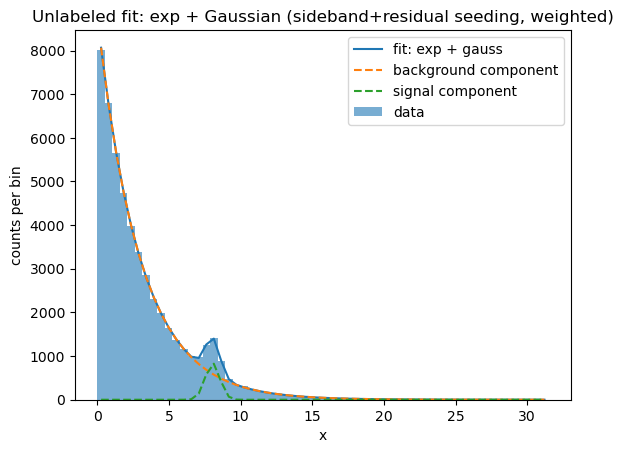

In [27]:
# --- 7. Plot components ---
y_fit = full_counts(centers, *pars)
y_bkg = bkg_counts(centers, B, tau)
y_sig = width * (S * gauss_pdf(centers, mu, sigma))

plt.figure()
plt.bar(centers, counts, width=width, alpha=0.6, label="data")
plt.plot(centers, y_fit, label="fit: exp + gauss")
plt.plot(centers, y_bkg, "--", label="background component")
plt.plot(centers, y_sig, "--", label="signal component")
plt.xlabel("x")
plt.ylabel("counts per bin")
plt.title("Unlabeled fit: exp + Gaussian (sideband+residual seeding, weighted)")
plt.legend(); plt.show()